## Customer Churn Detection

* `Importing Libraries`

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# sklearn - preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# imblearn
from imblearn.over_sampling import SMOTE

# sklearn - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# sklearn - metrics
from sklearn.metrics import confusion_matrix, f1_score


* `Read data`

In [132]:
FILEPATH = os.path.join(os.getcwd(), "dataset.csv")
df = pd.read_csv(FILEPATH)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [133]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [134]:
df.shape

(10000, 14)

In [135]:
# drop unusful features
df.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True)

In [136]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [137]:
# show statistics of the numeric data
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [138]:
# show statistics of the categorical data
df.describe(include="object")

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


* `Exploratory data analysis`

In [139]:
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [140]:
# Apply some feature engineering
df["withdrawing"] = abs(df["EstimatedSalary"] - df["Balance"])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,withdrawing
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,28734.72
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,45729.23
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,46426.72


In [141]:
df["Geography"].value_counts(normalize=True)

Geography
France     0.5014
Germany    0.2509
Spain      0.2477
Name: proportion, dtype: float64

In [142]:
df["Gender"].value_counts(normalize=True)

Gender
Male      0.5457
Female    0.4543
Name: proportion, dtype: float64

In [143]:
df["Exited"].value_counts(normalize=True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

---

### `Data Viz & Data Handling`

* `Univariate Viz`

In [144]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
withdrawing        float64
dtype: object

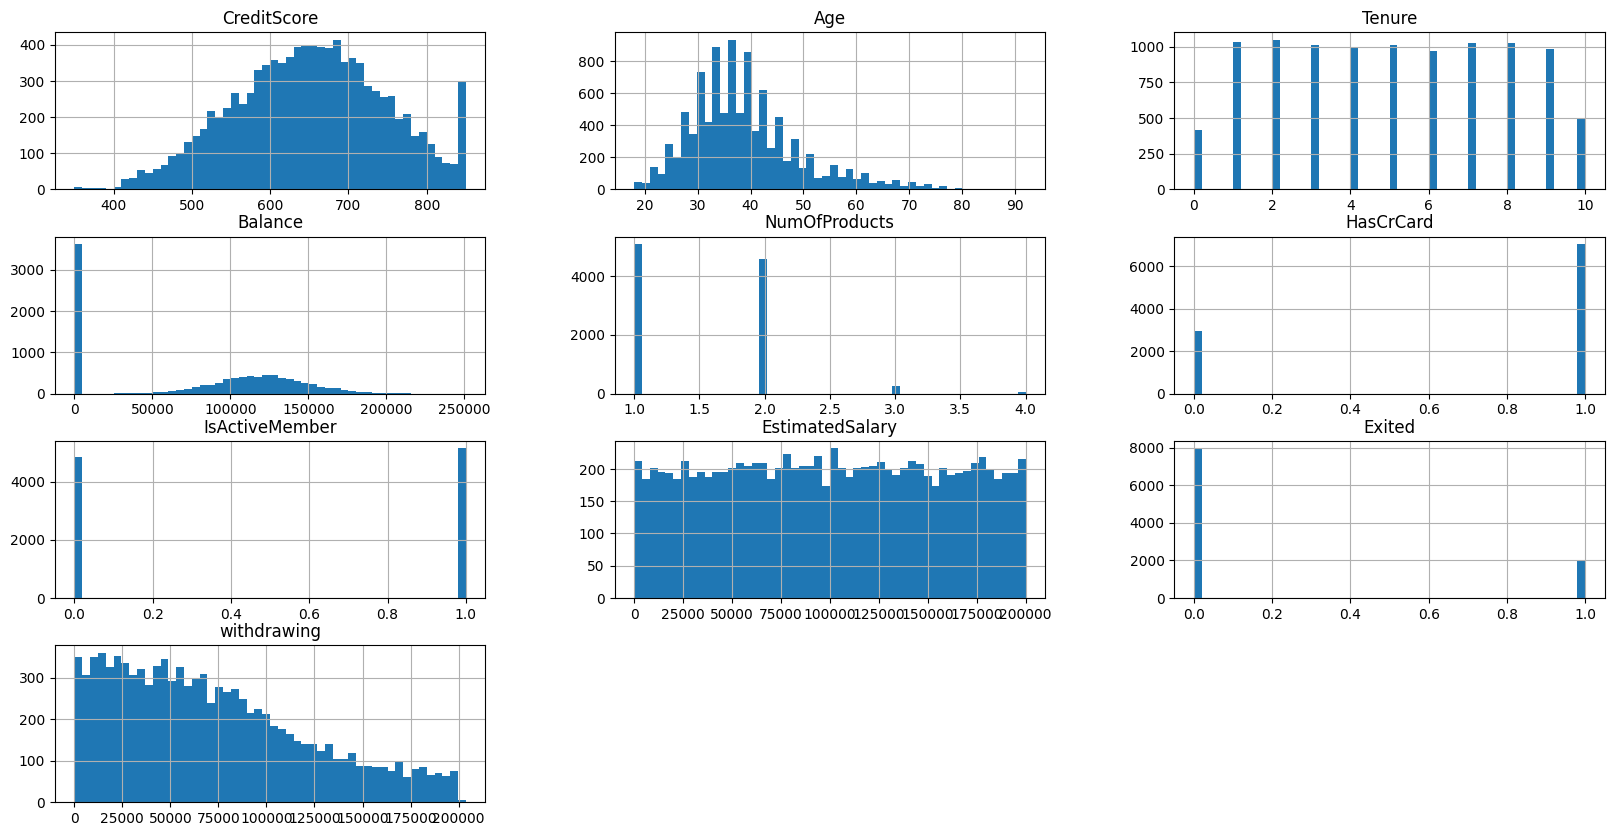

In [145]:
df.hist(bins=50, figsize=(20, 10))
plt.show()

In [146]:
# Handle Outliers
df.drop(index=df[df["Age"] > 80].index.tolist(), axis=0, inplace=True)

KeyboardInterrupt: 

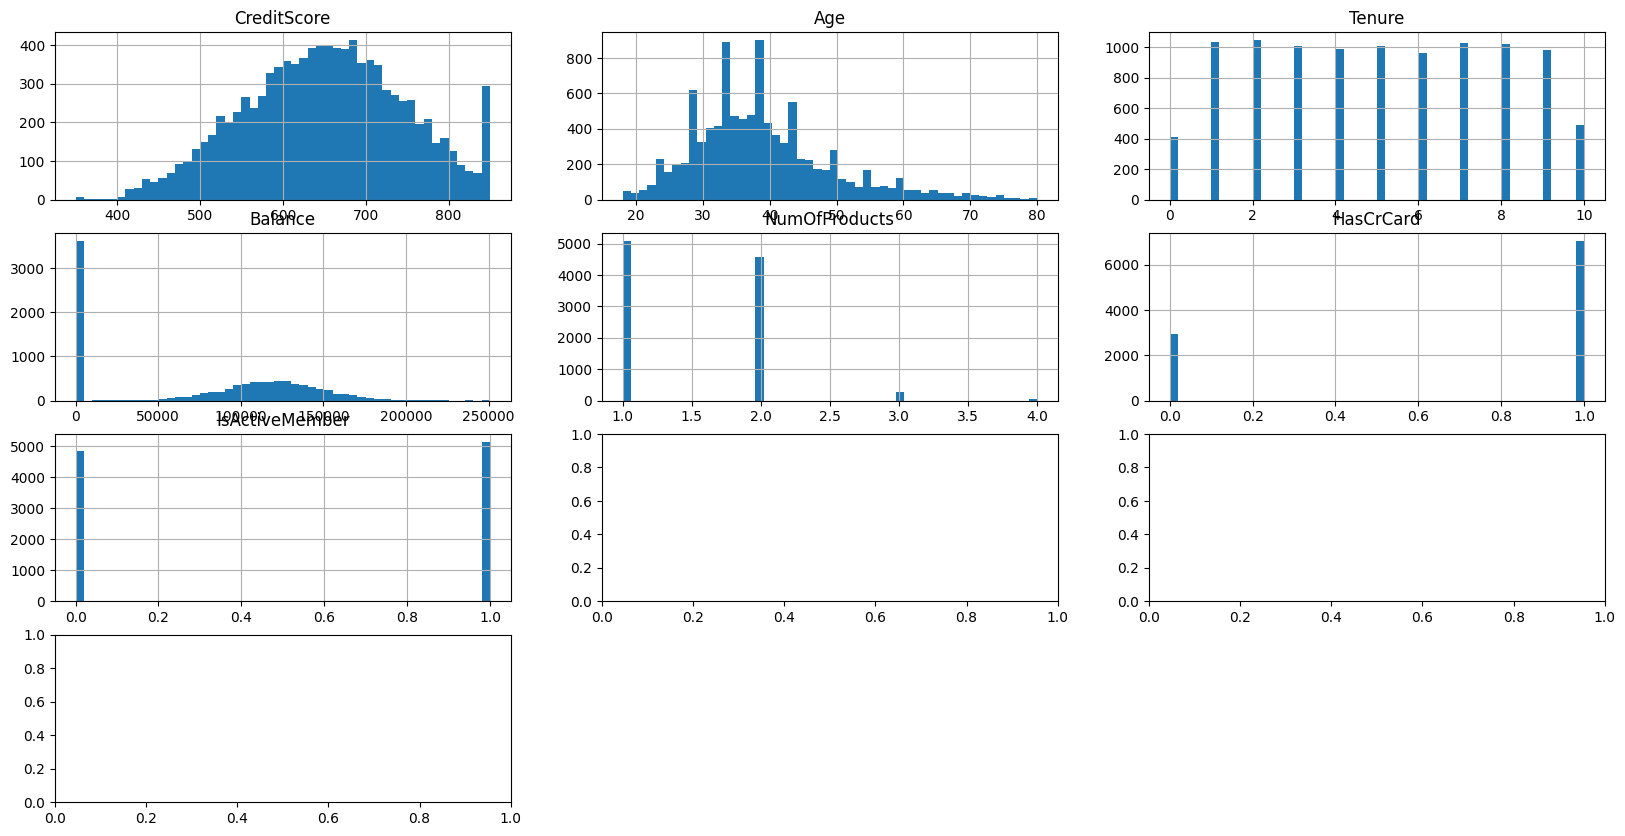

In [147]:
# Histograms after handling age coloumn
df.hist(bins=50, figsize=(20, 10)) 
plt.show()

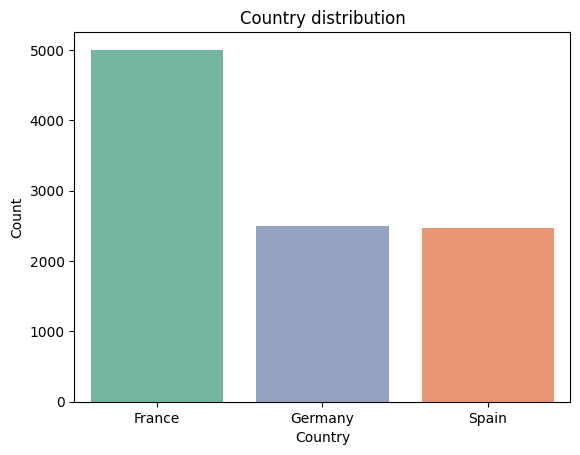

In [ ]:
# Countplot for Geography Column
sns.countplot(df, x="Geography", order=df["Geography"].value_counts().index.tolist(), palette="Set2", legend=False, hue="Geography")

plt.title("Country distribution")
plt.xlabel("Country")
plt.ylabel("Count")
plt.show()

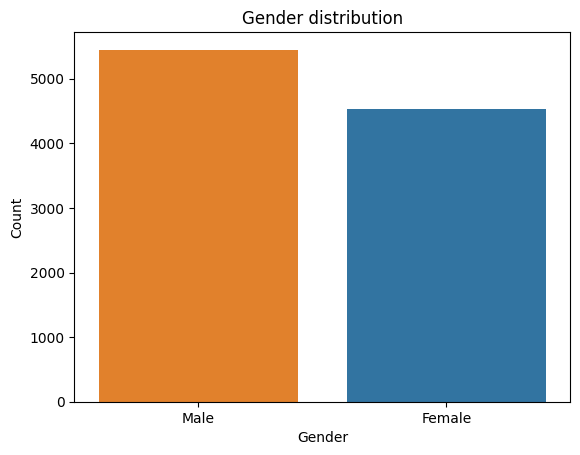

In [ ]:
# Countplot for Gender Column
sns.countplot(df, x="Gender", order=df["Gender"].value_counts().index.tolist(), legend=False, hue="Gender")

plt.title("Gender distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

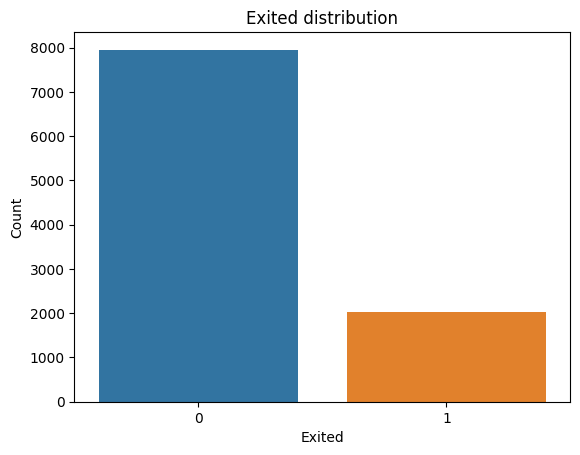

In [ ]:
# Countplot for Exited target
sns.countplot(df, x="Exited", order=df["Exited"].value_counts().index.tolist(), legend=False, hue="Exited")

plt.title("Exited distribution")
plt.xlabel("Exited")
plt.ylabel("Count")
plt.show()

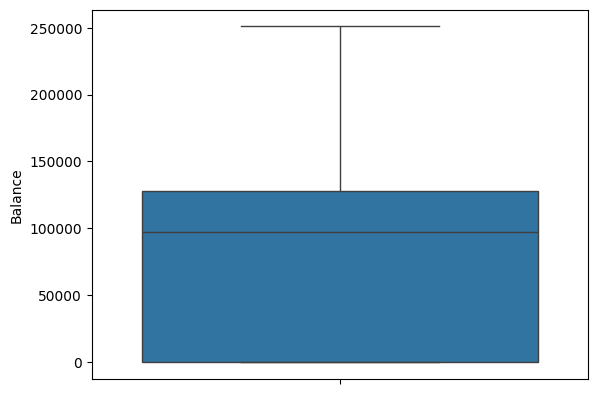

In [ ]:
sns.boxplot(df, y=df["Balance"])
plt.show()

* `Bivariante Viz`

In [ ]:
# Average Salary per Gender
df[["Gender", 'EstimatedSalary']].groupby("Gender")["EstimatedSalary"].mean()

Gender
Female    100575.998277
Male       99671.901194
Name: EstimatedSalary, dtype: float64

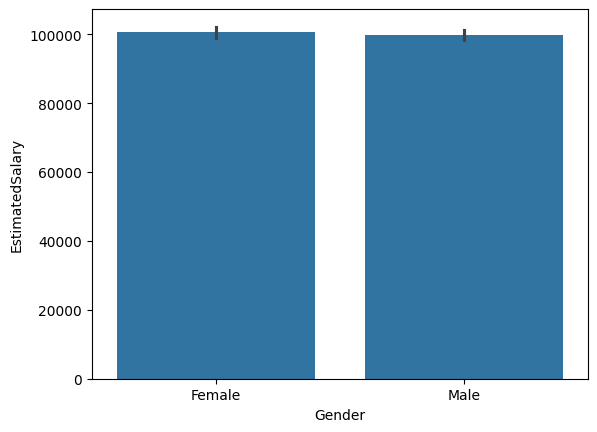

In [ ]:
# Average Salary per Gender using barplot
sns.barplot(df, x="Gender", y="EstimatedSalary", estimator='mean')
plt.show()

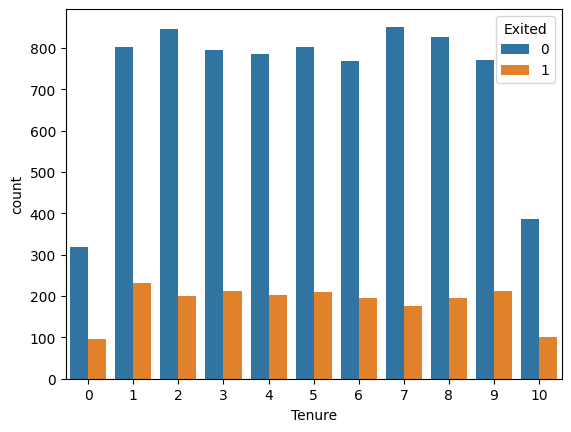

In [ ]:
# Realation between Tenure and Exited
sns.countplot(data=df, x='Tenure', hue='Exited')
plt.show()

In [ ]:
df[["Geography", 'Exited']].groupby("Geography")["Exited"].sum()

Geography
France     809
Germany    814
Spain      413
Name: Exited, dtype: int64

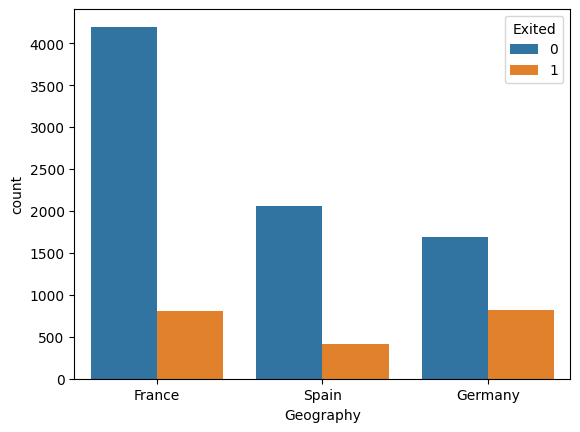

In [ ]:
# Relation between Geography and exited customers
sns.countplot(df, x="Geography", hue="Exited")
plt.show()

---

* `Splitting dataset into train & test`

In [ ]:
X = df.drop(columns="Exited", axis=1)
y = df["Exited"]

y.value_counts(normalize=True)

Exited
0    0.796155
1    0.203845
Name: proportion, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

## Train data stratified on y
# train data = 0.8 * 0.796155 * 9988 + 0.8 * 0.203845 * 9988
print('X_train.shape \t', X_train.shape)
print('y_train.shape \t', y_train.shape)
print(0.8 * 0.796155 * 9988 + 0.8 * 0.203845 * 9988)
print('***'*10)
## Test data stratified on y
# test data = 0.2 * 0.796155 * 9988 + 0.2 * 0.203845 * 9988
print('X_test.shape \t', X_test.shape)
print('y_test.shape \t', y_test.shape)
print(0.2 * 0.796155 * 9988 + 0.2 * 0.203845 * 9988)

X_train.shape 	 (7990, 11)
y_train.shape 	 (7990,)
7990.400000000001
******************************
X_test.shape 	 (1998, 11)
y_test.shape 	 (1998,)
1997.6000000000001


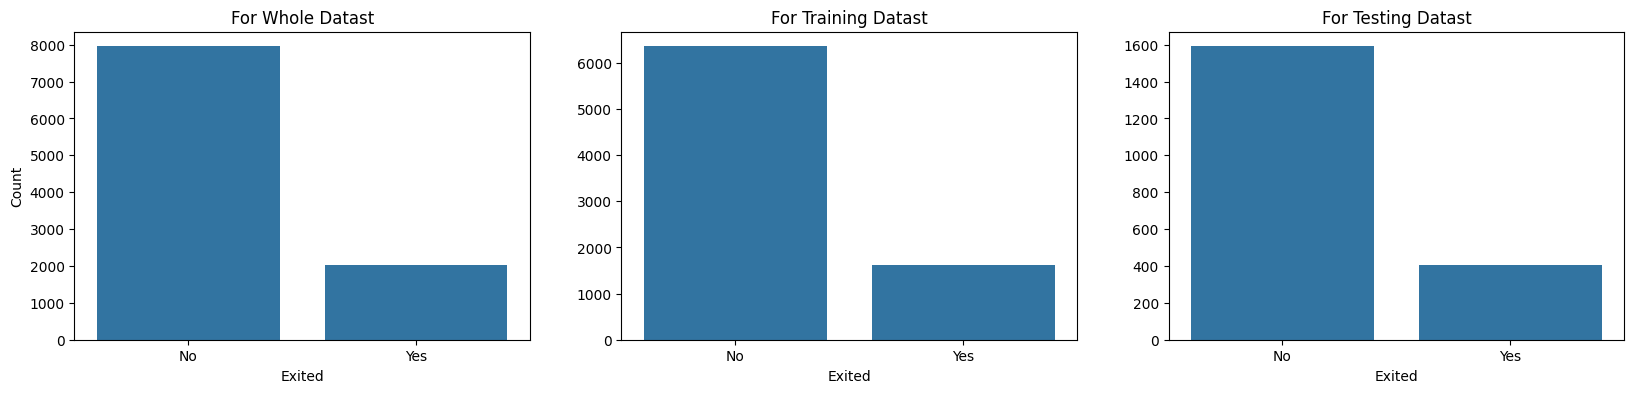

In [ ]:
## plottting to check
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

## Whole dataset
plt.sca(ax[0])
sns.countplot(x=y)
plt.title('For Whole Datast')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

## train
plt.sca(ax[1])
sns.countplot(x=y_train)
plt.title('For Training Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

## test
plt.sca(ax[2])
sns.countplot(x=y_test)
plt.title('For Testing Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

---

* `Data preprocessing & Pipline`

In [ ]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,withdrawing
3544,731,Spain,Male,33,1,0.00,1,1,0,130726.96,130726.96
1884,656,France,Male,35,6,0.00,2,1,0,1485.27,1485.27
8685,772,France,Male,43,6,0.00,2,1,1,57675.88,57675.88
6259,585,Germany,Female,28,9,135337.49,2,1,1,40385.61,94951.88
4136,651,France,Male,44,2,0.00,3,1,0,102530.35,102530.35


In [ ]:
X_train.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'withdrawing'],
      dtype='object')

In [ ]:
# Splitting the columns
num_cols = []
categ_cols = []

for col in X_train.columns:
    if isinstance(X_train[col][0], str):
        categ_cols.append(col)
    else:
        num_cols.append(col)

ready_cols = ["Tenure",	"NumOfProducts", "HasCrCard", "IsActiveMember"]
num_cols = list(set(num_cols) - set(ready_cols))

print(f"numerical columns: {num_cols}")
print(f"categorical columns: {categ_cols}")
print(f"Ready columns {ready_cols}")
len(X_train.columns)

numerical columns: ['Age', 'withdrawing', 'Balance', 'EstimatedSalary', 'CreditScore']
categorical columns: ['Geography', 'Gender']
Ready columns ['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']


11

In [ ]:
# Pipline

# Numerical: num_cols --> Imputing using median, and StandardScaler
# Categorical: categ_cols --> Imputing using mode, and OHE
# Ready Cols: ready_cols --> Imputing mode

# For numerical
num_pipline = Pipeline(steps=[
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler())
])

# For Categorical
categ_pipline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("ohe", OneHotEncoder(sparse_output=False, drop='first'))
])

# For Ready Cols
ready_pipeline = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent'))
                ])

all_pipeline = ColumnTransformer(transformers=[
    ("numerical", num_pipline, num_cols), 
    ("categorical", categ_pipline, categ_cols),
    ("ready", ready_pipeline, ready_cols)
])

# Apply
X_train_final = all_pipeline.fit_transform(X_train)
X_test_final = all_pipeline.transform(X_test)

In [ ]:
# If you want to see the processed array
output_cols = num_cols + all_pipeline.named_transformers_['categorical'].named_steps['ohe'].get_feature_names_out(categ_cols).tolist() + ready_cols

pd.DataFrame(X_train_final, columns=output_cols)

,Age,withdrawing,Balance,EstimatedSalary,CreditScore,Geography_Germany,Geography_Spain,Gender_Male,Tenure,NumOfProducts,HasCrCard,IsActiveMember
0,-0.562626,1.174927,-1.236191,0.524526,0.838045,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,-0.368793,-1.397426,-1.236191,-1.725057,0.062850,0.0,0.0,1.0,6.0,2.0,1.0,0.0
2,0.406541,-0.279040,-1.236191,-0.747003,1.261818,0.0,0.0,1.0,6.0,2.0,1.0,1.0
3,-1.047210,0.462880,0.939502,-1.047957,-0.671001,1.0,0.0,0.0,9.0,2.0,1.0,1.0
4,0.503457,0.613718,-1.236191,0.033735,0.011170,0.0,0.0,1.0,2.0,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7985,-1.047210,-1.035824,-1.236191,-1.408828,0.796701,0.0,0.0,1.0,5.0,2.0,0.0,1.0
7986,1.278791,-0.300607,0.319672,0.918716,0.496959,1.0,0.0,1.0,8.0,1.0,1.0,1.0
7987,-1.337960,2.147846,-1.236191,1.375367,0.279904,0.0,0.0,0.0,3.0,2.0,1.0,0.0
7988,0.212707,1.444534,-1.236191,0.760303,0.372928,0.0,0.0,0.0,10.0,1.0,1.0,1.0


In [ ]:
# Check train
X_train_final.shape, y_train.shape

((7990, 12), (7990,))

In [ ]:
# Check test
X_test_final.shape, y_test.shape

((1998, 12), (1998,))

In [ ]:
# Dump the pipeline locally in ARTIFACTS_FOLDER_PATH
ARTIFACTS_FOLDER_PATH = os.path.join(os.getcwd(), '..', 'artifacts')
os.makedirs(ARTIFACTS_FOLDER_PATH, exist_ok=True)

In [ ]:
# Dump the pipeline locally --> Serialzation
joblib.dump(all_pipeline, os.path.join(ARTIFACTS_FOLDER_PATH, 'pipeline.pkl'))

['c:\\Users\\YUSSEF\\OneDrive\\Desktop\\Projects\\Customer_Churn_Model\\Notebooks\\..\\artifacts\\pipeline.pkl']

---

* `Dealing with Imbalancing data`

In [148]:
# 1. Wihtout Considering any solution for dealing with imbalanced data --- (X_train_final, y_train)

# 2. Use class_weight for solving imbalanced weight --- (X_train_final, y_train) & model class_weigth=dict_weights
vals_count = 1 - (np.bincount(y_train) / len(y_train))
vals_count = vals_count / np.sum(vals_count)
dict_weights = {}
for i in range(2):  # 2 classes (0, 1)
    dict_weights[i] = vals_count[i]


In [150]:
# 3. Consider using oversampling using SMOTE   --- (X_train_resampeld, y_train_resampled)
over = SMOTE(sampling_strategy=0.65)
X_train_resampeld, y_train_resampled = over.fit_resample(X_train_final, y_train)

---

### `Building Models`

> Evaluation Metric is F1-score

* `Logistic Regression`

In [151]:
# 1. Using logistic -- without considering the imabalancing data
log_clf = LogisticRegression(C=1.5, penalty='l2')
log_clf.fit(X_train_final, y_train)

# Predict and evalute
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# F1-Score
f1_train_log = f1_score(y_train, y_pred_train_log)
f1_test_log = f1_score(y_test, y_pred_test_log)

print(f'The f1_score using Logistic model for Training Dataset is: {f1_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is: {f1_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset is: 31.275
The f1_score using Logistic model for Testing Dataset is: 35.439


In [152]:
# 2. Using logisit -- with considering the imabalancing data using class_weights
log_clf = LogisticRegression(C=1.5, penalty='l2', class_weight=dict_weights)
log_clf.fit(X_train_final, y_train)

# Predict and evalute
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# F1-Score
f1_train_log = f1_score(y_train, y_pred_train_log)
f1_test_log = f1_score(y_test, y_pred_test_log)

print(f'The f1_score using Logistic model for Training Dataset with class_weigths is {f1_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset with class_weigths is {f1_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset with class_weigths is 50.077
The f1_score using Logistic model for Testing Dataset with class_weigths is 48.282


In [153]:
# 3. Using logisit -- with considering the imabalancing data using oversampled data (SMOTE)
log_clf = LogisticRegression(C=1.5, penalty='l2')
log_clf.fit(X_train_resampeld, y_train_resampled)

# Predict and evalute
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# F1-Score
f1_train_log = f1_score(y_train, y_pred_train_log)
f1_test_log = f1_score(y_test, y_pred_test_log)


print(f'The f1_score using Logistic model for Training Dataset with SMOTE is {f1_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset with SMOTE is {f1_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset with SMOTE is 49.426
The f1_score using Logistic model for Testing Dataset with SMOTE is 50.056


In [154]:
# Dump this model locally
joblib.dump(log_clf, os.path.join(ARTIFACTS_FOLDER_PATH, 'logistic-with-smote.pkl'), compress=9)

['c:\\Users\\YUSSEF\\OneDrive\\Desktop\\Projects\\Customer_Churn_Model\\Notebooks\\..\\artifacts\\logistic-with-smote.pkl']

---